Created by Anand Sivaramakrishnan  2018 12 28

Adapted to a Jupyter Notebook by Keira Brooks 2019 01 14 
- This adapted version does not do any file saving/reading; it displays all plots that
    saved in the script version
- If you want a version the depends on saving and reading files, please refer
  to the original script: gerchbergsaxton.py
 
 Changes to plotting scaling, limits Anand Sivaramakrishnan  2019 01 15


This file is licensed under the Creative Commons Attribution-Share Alike
license versions 3.0 or higher, see
http://creativecommons.org/licenses/by-sa/3.0/

Python 3

    matrixDFT.perform():  (also matrixDFT.inverse():)
    Parameters
    ----------
    plane : 2D ndarray
            2D array (either real or complex) representing the input 
            image plane orpupil plane to transform.
    nlamD : float or 2-tuple of floats (nlamDY, nlamDX)
            Size of desired output region in lambda / D units, assuming that 
            the pupil fills the input array (corresponds to 'm' in
            Soummer et al. 2007 4.2). This is in units of the spatial
            frequency that is just Nyquist sampled by the input array.) If 
            given as a tuple, interpreted as (nlamDY, nlamDX).
    npix : int or 2-tuple of ints (npixY, npixX)
           Number of pixels per side side of destination plane array 
           (corresponds to 'N_B' in Soummer et al. 2007 4.2). This will be 
           the # of pixels in the image plane for a forward transformation, 
           in the pupil plane for an inverse. If given as a tuple,
           interpreted as (npixY, npixX).


In [1]:
### Libraries/modules

import os, sys
import astropy.io.fits as fits
import numpy as np
import poppy.matrixDFT as matrixDFT
import utils

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

/Users/anand/anaconda3/envs/astroconda/lib/python3.5/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in /Users/anand/data/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/anand/anaconda3/envs/astroconda/lib/python3.5/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/anand/data/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/anand/anaconda3/envs/astroconda/lib/python3.5/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/anand/data/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


In [2]:
PUPIL = "pupil"
IMAGE = "image"

In [3]:
# This will set up default printing of numpy to 3 dec places, scientific notation
np.set_printoptions(precision=3, threshold=None, edgeitems=None, linewidth=None,
                    suppress=None, nanstr=None, infstr=None, 
                    formatter={'float': '{: 0.3e}'.format} )

In [4]:
def create_input_datafiles(rfn=None):
    """
        Pupil and image data, true (zero mean) phase map (rad) 
        No de-tilting of the thase done.
        Didactic case, no input parameters: create the pupil & monochromatic image 
        on appropriate pixel scales.  
        Pupil and image arrays of same size, ready to FT into each 
        other losslessly.  For real data you'll need to worry about adjusting
        sizes to satify this sampling relation between the two planes.
        For finite bandwidth data image simulation will loop over wavelengths.
        For coarsely sampled pixels image simulation will need to use finer
        sampling and rebin to detector pixel sizes.
        anand@stsci.edu Jan 2019
    """
    pupil0 = utils.makedisk(250, radius=50) # D=100 pix, array 250 pix
    pupil1 = (pupil0 - utils.makedisk(250, radius=15, ctr=(125.0,75.0)))*pupil0
    pupil2 = (pupil1 - utils.makedisk(250, radius=15, ctr=(90.0,90.0)))*pupil0
    pupil3 = (pupil2 - utils.makedisk(250, radius=15, ctr=(75.0,125.0)))*pupil0

    pupils = [pupil0, pupil1, pupil2, pupil3]
    pupils = [pupil0, pupil3]
    phases = []
    imgs = []
    for pnum, pupil in enumerate(pupils):
        offctrbump=(pupil.shape[0]/2.0+30,pupil.shape[1]/2.0+20.0)  # off-center bump
        ctrbump=(pupil.shape[0]/2.0,pupil.shape[1]/2.0)  # central bump
        #quarter wave phase bump, off center
        phase = (2.0*np.pi/4.0) * utils.makegauss(pupil.shape[0], 
                                                  ctr=offctrbump, 
                                                  sigma=10.0) * pupil
        phase = de_mean(phase, pupil) # zero mean phase - doesn't change image
        mft = matrixDFT.MatrixFourierTransform()
        imagefield = mft.perform(pupil * np.exp(1j*phase), pupil.shape[0], pupil.shape[0])
        image = (imagefield*imagefield.conj()).real 
        
        phases.append(phase)
        imgs.append(image)


        fig, ax = plt.subplots(1, 3, figsize=(20,8))
        ax[0].imshow(pupil, origin='lower')
        ax[0].set_title('Pupil plane {:1d}')
        ax[1].imshow(phase, origin='lower', norm=LogNorm())
        ax[1].set_title("True phase {:1d}".format(pnum))
        ax[2].imshow(image[100:150, 100:150]/image.sum(), origin='lower', norm=LogNorm())
        ax[2].set_title("Image plane {:1d}".format(pnum))
        plt.show()
        
        del mft
    return pupils, phases, imgs

def arraystats(phase):
    return "mean {:+.4e}  sigma {:+.4e}  max {:+.4e}  min {:+.4e} ".format(
            phase.mean(), phase.std(), phase.max(), phase.min())
    
def phase_changes(pupil, interior, phase_old, phase_new, gain):
    """
        pupil: binary pupil array (grey edges OK)
        interior: one pixel clear of pupil edge, 0/1 array
        phase_old, phase_new: phase arrays to compare after de-meaning, de-tilting
        gain: the damping factor applied to the correction
        returns b - a phase difference array, standard dev of this phase difference,
        and the damped next phase to use

        interior unused here because we did not measure tilts of wavefronts
    """
    dphase = (phase_new - phase_old) * pupil
    newphase = (phase_old + gain*dphase) * pupil # next iteration's pupil phase
    newphase = de_mean(newphase, pupil)

    return dphase, dphase[np.where(np.greater(pupil,0))].std(), newphase

def de_mean(a, pupil):
    """ 
        remove the mean where there is live pupil (0/1)
    """
    return (a - a[np.where(pupil==1)].mean()) * pupil
    
def meantilt(a, support):
    """
        a: array like an OPD which you want to measure the mean tilt of.
        support_idx: indices array of region over which to take the mean of the tilts
        returns: (2-tuple) the mean tilt over the index array, in ["a" units] per pixel  
        TBD: for really accurate work you should take the pixels either side and 
        calculate the 'unbiased' tilt over the interior.

        In this 2018 version I changed tilt signs so higher value of array at
        higher index is positive tilt
        Remove tilt with 
        phasea[pupil_idx] -= ta[0]*pupil_idx[0] - ta[1] * pupil_idx[1] ?? (untested)
    """
    support_idx = np.where(support==1)
    xt,yt  = (np.zeros(a.shape), np.zeros(a.shape))
    xt[:-1,:] = a[1:,:] - a[:-1,:] 
    yt[:,:-1] = a[:,1:] - a[:,:-1] 
    print("\tMean tilt vector = {:.4e}, {:.4e}".format(xt[support_idx].mean(), yt[support_idx].mean()))
    return xt[support_idx].mean(), yt[support_idx].mean() # pure python x,y

def interior(pup):
    """ The interior of a pupil, one pixel either side is clear of the pupil edge
        Used to calculate average tilt over the pupil
        Only works for unapodized (grey edge pixels OK)
            mA,mB = meantilt(opd, np.where(insideNRM()==1))
            print "mA,mB  %8.1e  %8.1e  rad/pix  //  " % (mA, mB), 
    """
    support = np.where(np.equal(pup, 1), 1, 0)
    support[1:,:] =   support[1:,:]  * support[:-1, :]  #clip_loY ds9
    support[:-1,:] =  support[:-1,:] * support[1:, :]   #clip_hiY ds9
    support[:,1:] =   support[:,1:]  * support[:,:-1]   #clip_loX ds9
    support[1:,:] =   support[1:,:]  * support[:-1, :]  #clip_loY ds9
    return support.astype(np.uint8)


def powerfunc(carr):
    return ((carr*carr.conj()).real).sum()


In [5]:
class GerchbergSaxton:
    """
    Does a Gerchberg Saxton in focus phase retrieval example case without noise
    Uses lossless transforms both ways (like an fft but a dft is used for didactic clarity)

    Usage:

        import GerchbergSaxton as GS

        # create or obtain pupil with obstructions, apodizations
        pupilfn = None # creates pupil
        initphase = None # First guess at pupil phase array (radians wavefront) or None
        damp=0.3, # pupil phase correction  damping, dimensionless, <= 1 # UNUSED for clean didactc demonstration

        # read in or obtain intensity data from in-focus image
        # this data is on the sama angular scale as a lossless dft 
        # of the pupil array, for simplicity.  Trim it appropriately
        # ahead of time if necessary.
        imagefn = None # creates image with a gaussian phase bump aber

        # Save the first 5 iterations, then every 10th iteration
        # eg 1 2 3 4 5 10 20...
        history = (5,10) 

        # rms phase change threshold for convergence (radians wavefront)
        threshold = 0.1 # context:  Marechal approx gives Strehl 99% for phase rms 0.1

        # max number of iterations (phase, image, back to next phase)
        maxiter = 30

        # output file(s) root name
        fileroot = "GSdir/gstest"
        input files names will be appended to the fileroot

        # read in or obtain first guess of the wavefront phase in pupil
        gs = GS.GerchbergSaxton(pupilfn=pupilfn, 
                                imagefn=imagefn,
                                truephasefn=truephasefn,
                                outputtag="2", # kluge to match the numbered files for 4 didactic cases...
                                initphase=phase,  # initial guess, rad
                                damp=damp, # pupil phase iteration damping, dimensionless, < 1 or None (uses 1)
                                history=history, # record of which iterations you want to save for inspection later
                                threshold=threshold, # stop iterating when wavefront rms <= this, rad
                                maxiter=maxiter, # stop iterating after these number of iterations
                                fileroot=fileroot, # file name root for history
                                verbose=True,
                                )
        gs.gsloop()

    """

    def __init__(self, pupil=None, image=None, truephase=None, outputtag=0,
                 initphase=None, damp=None, history=None, threshold=0.1,  
                 maxiter=None, fileroot=None, verbose=True, save=False):
        """
        Assumes square arrays, equal sized arrays for pupil, image
        Iterations are pupil - to image - to pupil
        
        Note: Strehl 99% ~ 1 - threshold^2
        """

        # Requested attributes:
        self.damp = damp
        self.history = history
        self.threshold = threshold 
        self.maxiter = maxiter
        self.fileroot = fileroot
        self.verbose = verbose
        self.save = save
        self.tag = outputtag
        
        # Get data from input or from file
        
        self.pupil = pupil
        self.image = image/image.sum()
        self.truephase = truephase

        # Now for derived attributes:
        if initphase is None:
            self.initphase = self.pupil*0.0 # initial phase guess
        else:
            self.initphase = initphase
        self.phase = self.initphase.copy()
        self.pupilpower = (self.pupil*self.pupil).sum()
        self.mft = matrixDFT.MatrixFourierTransform()
        self.npix = self.pupil.shape[0] # size of the arrays
        # create interior of an unapodized pupil, for calculating mean tilts
        self.interior = interior(self.pupil)

        # Create initial guess at wavefront
        self.plane = PUPIL
        self.wavefront = self.pupil * np.exp(1j * self.phase)

        # List of phases (32bit) to track evolution of GS
        self.iter = 0 # running count
        self.savediters = [-1,] 
        self.pupilintensities = [self.pupil,]  
        self.pupilphases = [self.initphase,]  
        self.imageintensities = [self.image,] 

        print("\nmaxiter {:d}  convergence if sigma < {:.2e}\n".format(self.maxiter, self.threshold))

    def apply_pupil_constraint(self, ):
        """
        Replace absolute value of wavefront by pupil values, preserve the current phase
        """
        if self.plane == PUPIL:
            # this new phase estimate comes from the image plane tranformed to this pupil
            nextphase = np.angle(self.wavefront) * self.pupil

            # check to see how the guess at the wavefront is changing...
            if self.verbose: 
                fig, ax = plt.subplots(1, 2, figsize=(20,8))
                ax[0].imshow(self.interior)
                ax[0].set_title("{} Interior".format(self.tag))
                ax[1].imshow(nextphase)
                ax[1].set_title("{} Next phase".format(self.tag))
                plt.show()

            self.phasedelta, phasedeltarms, dampednextphase = phase_changes(self.pupil, self.interior, 
                                                                      self.phase, nextphase, self.damp)
            print("\t{:3d}: Delta Phase stats: {:s} ".format(self.iter, 
                                                       arraystats(self.phasedelta[np.where(self.pupil==1)])))

            # update wavefront with the new phase estimate
            self.wavefront = self.pupil * np.exp(1j*dampednextphase)
            self.phase = dampednextphase
            return phasedeltarms
        else:
            sys.exit(" gerchbergsaxton.apply_pupil_constraint(): being used in the wrong plane")

    def apply_image_constraint(self, ):
        """
        Replace absolute value of wavefront by sqrt(image), preserve the current phase
        """
        if self.plane == IMAGE:
            self.imagephase = np.angle(self.wavefront)
            self.wavefront = np.sqrt(self.image) * np.exp(1j*self.imagephase)
            if self.verbose: print("\timage power {:.4e}".format(powerfunc(self.wavefront)))
            return None 
        else:
            sys.exit(" gerchbergsaxton.apply_image_constraint(): being used in the wrong plane")

    def propagate_wavefront(self, ):
        """
        Apply the appropriate transform to go to the next conjugate plane.
        """
        if self.plane == PUPIL:
            if self.verbose: print("  in pupil, going to image ")
            self.wavefront = self.mft.perform(self.wavefront, self.npix, self.npix)
            self.plane = IMAGE
        elif self.plane == IMAGE:
            if self.verbose: print("  in image, going to pupil ")
            wavefront = self.mft.inverse(self.wavefront, self.npix, self.npix)
            power = (wavefront * wavefront.conj()).real.sum()
            self.wavefront = wavefront/np.sqrt(power)
            self.plane = PUPIL
        else:
            sys.exit("GerchbergSaxton.propagate_wavefront() is confused: Neither pupil nor image plane")
        return None

    def iterate(self):
        """ iterate once, pupil to image then back to pupil,
            save data for the record if needed, 
            then apply pupil constraint again
        """
        if self.verbose: print("\niter:{:3d}".format(self.iter))
        self.propagate_wavefront() # pupil to image
        self.save_iteration()

        self.apply_image_constraint()

        self.propagate_wavefront() # image to pupil
        self.save_iteration()

        self.iter += 1

        rmsphasechange = self.apply_pupil_constraint()
        return rmsphasechange

    def save_iteration(self):
        """ keep a record of phases, intensities, etc.  """
        if self.iter in range(history[0]) or self.iter%history[1]==0:
            if self.plane == PUPIL:
                pupilintensity = (self.wavefront*self.wavefront.conj()).real
                pupilintensity = pupilintensity/pupilintensity.sum()*self.pupilpower # preserve input pupil power
                self.pupilintensities.append(pupilintensity) # preserve input pupil power
                self.pupilphases.append(self.pupil*np.angle(self.wavefront))
            if self.plane == IMAGE:
                imageintensity = (self.wavefront*self.wavefront.conj()).real
                self.imageintensities.append(imageintensity/imageintensity.sum()) # preserve unit image power
            self.savediters.append(self.iter)

    def gsplot(self):

        """ plot for inspection """
        fig, ax = plt.subplots(4, 6, figsize=(20,8))
        for i in range(6):
            ax[0, i].imshow(np.array(tuple(self.pupilintensities))[i][50:200,50:200], origin='lower',norm=LogNorm(vmin=0.9,vmax=1.1))
            ax[1, i].imshow(np.array(tuple(self.pupilintensities))[i][50:200,50:200], origin='lower',norm=LogNorm(vmin=1e-9,vmax=0.1))
            ax[2, i].imshow(np.array(tuple(self.pupilphases))[i][50:200,50:200], origin='lower',norm=LogNorm())
            ax[3, i].imshow(np.array(tuple(self.imageintensities))[i][100:150,100:150], origin='lower', norm=LogNorm())
        ax[0, 0].set_title("{}: Pupil intensity 0.9 - 1.1".format(self.tag))
        ax[1, 0].set_title("{}: Pupil intensity 1e-9 - 0.1".format(self.tag))
        ax[2, 0].set_title("{}: Pupil phase".format(self.tag))
        ax[3, 0].set_title("{}: Image intensity".format(self.tag))
        plt.tight_layout()
        plt.show()

        phase_meas_error = de_mean(self.truephase - self.pupilphases[-1], self.pupil)
        img_meas_error = self.image - self.imageintensities[-1]

        print("       Init Phase stats:  {:s} ".format(arraystats(self.truephase[np.where(self.pupil==1)])))
        print("       Final Phase stats: {:s} ".format(arraystats(self.pupilphases[-1][np.where(self.pupil==1)])))
        print("")
        print("Init - Final Phase stats: {:s} ".format(arraystats(phase_meas_error[np.where(self.pupil==1)])))
        print("       Image diff stats:  {:s} ".format(arraystats(img_meas_error)))
        print("")
        print("All phases in radians, images total power unity")
        
        fig, ax = plt.subplots(2, 2, figsize=(20,16))
        im = ax[0,0].imshow(self.imageintensities[-1][100:150,100:150], origin='lower', norm=LogNorm())
        ax[0,0].set_title("{} Final intensity".format(self.tag))
        ax[1,0].imshow(img_meas_error[100:150,100:150], origin='lower', norm=im.norm)
        ax[1,0].set_title("{} Error intensity".format(self.tag))
        ph = ax[0,1].imshow(self.pupilphases[-1], origin='lower')
        ax[0,1].set_title("{} Final phase".format(self.tag))
        ax[1,1].imshow(phase_meas_error, origin='lower', norm=ph.norm)
        ax[1,1].set_title("{} Error phase".format(self.tag))
        plt.show()


    def gsloop(self):
        """ The main GS loop.  """
        for iloop in range(self.maxiter + 1):
            if self.iterate() < self.threshold:
                print("\ngsloop terminated at iter {}\n".format(self.iter))
                break

        self.gsplot()


In [6]:
# create or obtain pupil with obstructions, apodizations
#pupilfn = None # creates pupil files, hardcoded single choice of pupill used
initphase = None # First guess at pupil phase array (radians wavefront) or None
damp = 1.0  # pupil phase correction  damping, dimensionless, <= 1 # UNUSED for clean didactc demonstration


In [7]:
# read in or obtain intensity data from in-focus image
# this data is on the sama angular scale as a lossless dft 
# of the pupil array, for simplicity.  Trim it appropriately
# ahead of time if necessary.
imagefn = None # creates image with a gaussian phase bump aber

In [8]:
# Save the first 9 iterations, then every 10th iteration
# eg 1 2 3 ... 9  10 20 30...
history = (9,10) 

In [9]:
# rms phase change standard deviation threshold for convergence (radians wavefront)
threshold = 1.0e-5 # radians

In [10]:
# max number of iterations (phase, image, back to next phase)
maxiter = 101

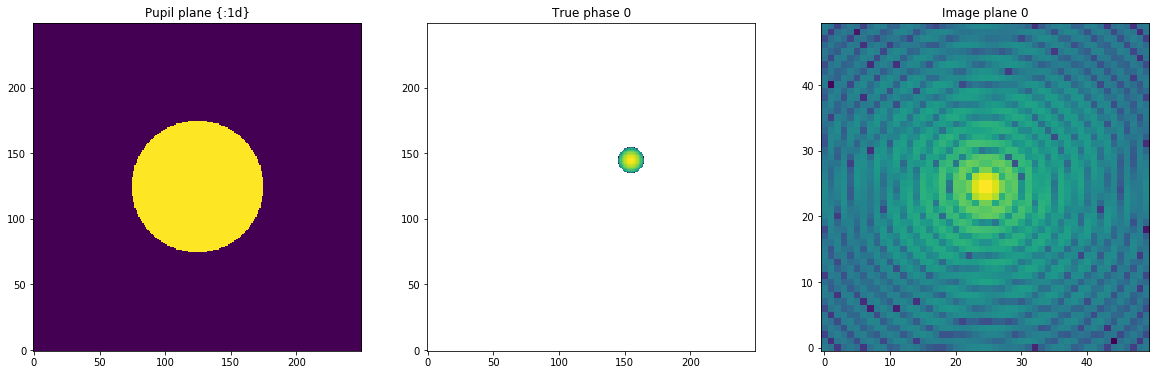

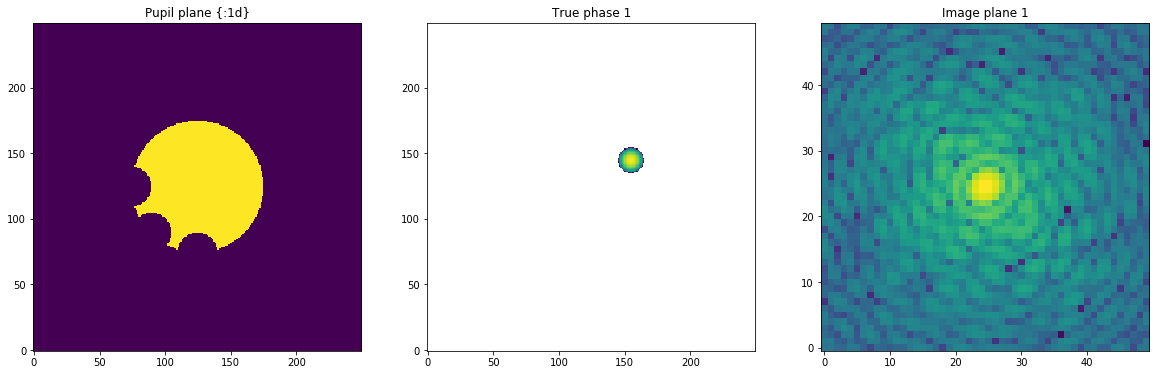

In [11]:
fileroot = "GSdir/gs"
# if fileroot doesn't exist. make it
if not os.path.exists(fileroot):
    os.makedirs(fileroot)

pupils, phases, imgs = create_input_datafiles(rfn=fileroot) # Return list of arrays pupil, image and true phase arrays
                                                            # These arrays are used in GS.pupilfn, GS.imagefn, GS.truephasefn



maxiter 101  convergence if sigma < 1.00e-05

	  1: Delta Phase stats: mean +1.8080e-18  sigma +6.2950e-02  max +6.6858e-01  min -6.6858e-01  
	  2: Delta Phase stats: mean +8.4750e-18  sigma +9.7547e-03  max +8.7584e-02  min -8.7584e-02  
	  3: Delta Phase stats: mean -1.4655e-18  sigma +1.1293e-03  max +5.5889e-03  min -5.5889e-03  
	  4: Delta Phase stats: mean -4.9477e-18  sigma +4.2778e-05  max +1.1476e-04  min -1.1476e-04  
	  5: Delta Phase stats: mean +4.7933e-18  sigma +4.0178e-15  max +7.6269e-15  min -7.6840e-15  

gsloop terminated at iter 5



/Users/anand/anaconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/Users/anand/anaconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/Users/anand/anaconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/image.py:412: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/anand/anaconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/image.py:417: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/Users/anand/anaconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/Users/anand/anaconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/colors.py:1034: RuntimeWa

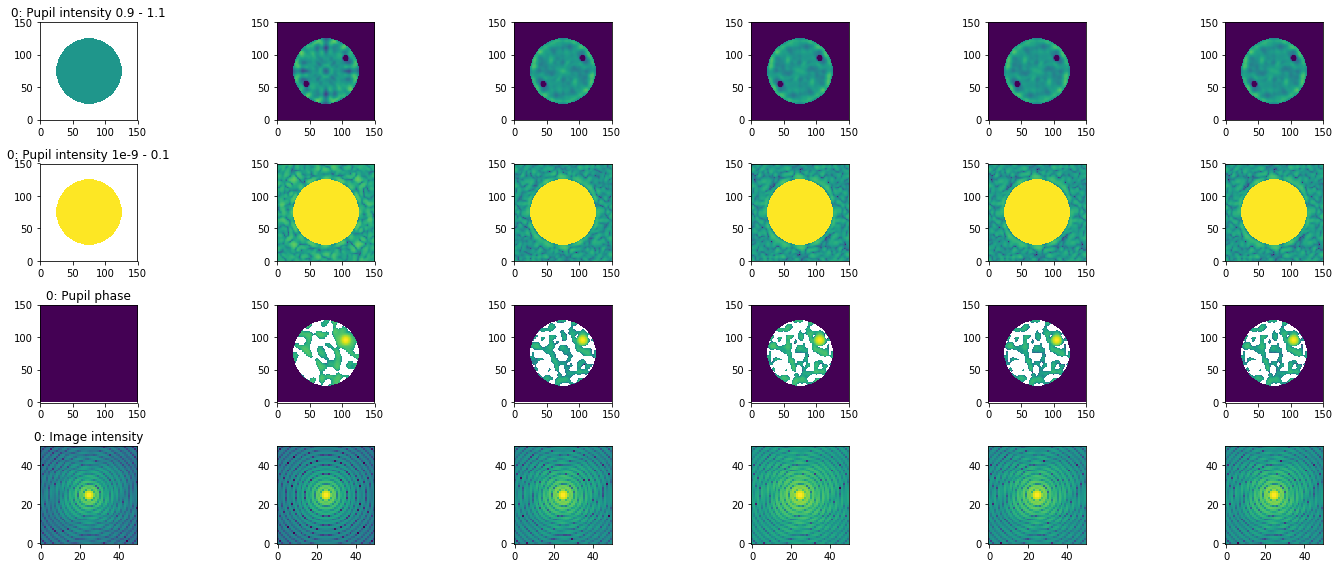

       Init Phase stats:  mean +9.0400e-19  sigma +9.8511e-02  max +1.5195e+00  min -1.2557e-02  
       Final Phase stats: mean +4.5200e-18  sigma +6.9876e-02  max +7.6024e-01  min -7.6024e-01  

Init - Final Phase stats: mean -9.0400e-19  sigma +6.9237e-02  max +7.6122e-01  min -2.6991e-02  
       Image diff stats:  mean +1.1149e-22  sigma +4.5270e-06  max +1.1576e-04  min -4.9958e-04  

All phases in radians, images total power unity


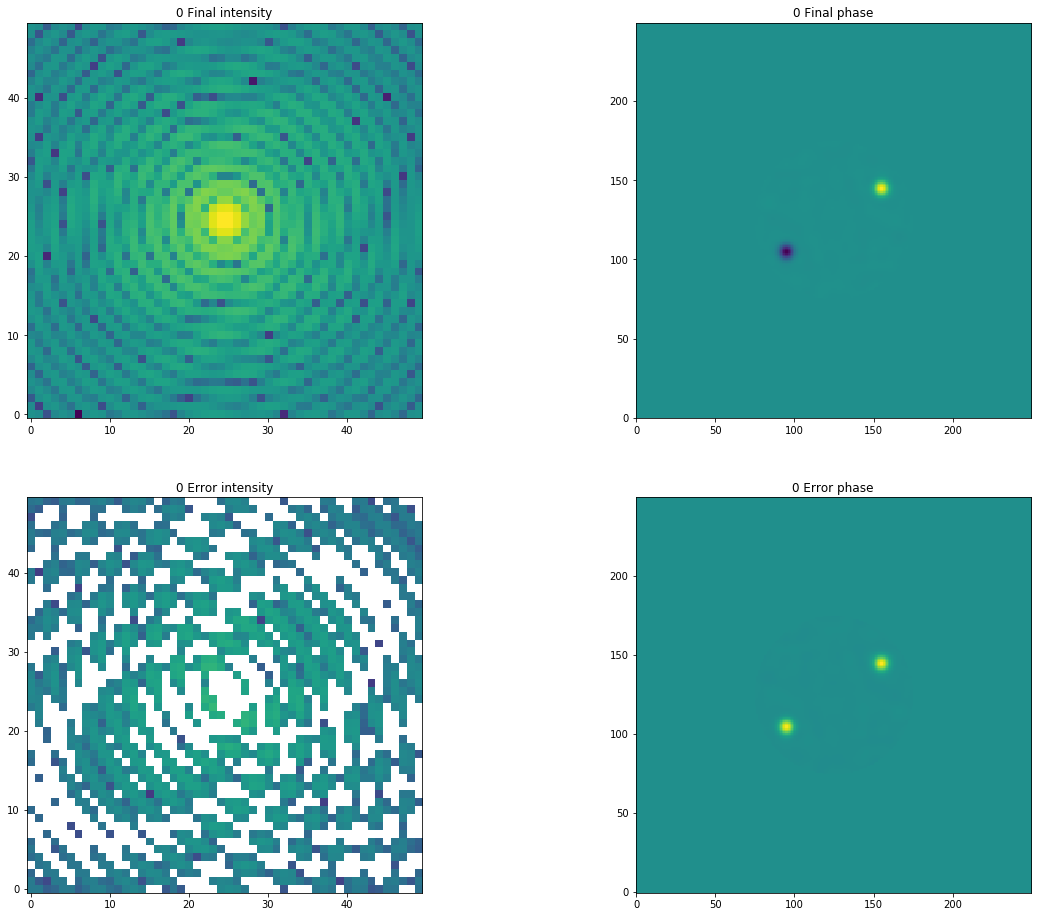


maxiter 101  convergence if sigma < 1.00e-05

	  1: Delta Phase stats: mean +5.5814e-04  sigma +5.6249e-02  max +7.1807e-01  min -1.2381e-01  
	  2: Delta Phase stats: mean +2.0760e-04  sigma +2.3530e-02  max +3.6222e-01  min -3.5584e-02  
	  3: Delta Phase stats: mean +9.1607e-05  sigma +1.3590e-02  max +2.0334e-01  min -1.5853e-02  
	  4: Delta Phase stats: mean +3.9226e-05  sigma +8.1868e-03  max +1.0930e-01  min -1.1061e-02  
	  5: Delta Phase stats: mean +1.7862e-05  sigma +5.1809e-03  max +5.6694e-02  min -8.9441e-03  
	  6: Delta Phase stats: mean +8.8535e-06  sigma +3.4893e-03  max +2.8698e-02  min -6.8713e-03  
	  7: Delta Phase stats: mean +4.7907e-06  sigma +2.5043e-03  max +1.6421e-02  min -5.3464e-03  
	  8: Delta Phase stats: mean +2.8219e-06  sigma +1.8992e-03  max +1.0695e-02  min -4.2289e-03  
	  9: Delta Phase stats: mean +1.8018e-06  sigma +1.5078e-03  max +7.5717e-03  min -3.3011e-03  
	 10: Delta Phase stats: mean +1.2404e-06  sigma +1.2459e-03  max +5.6763e-03  m

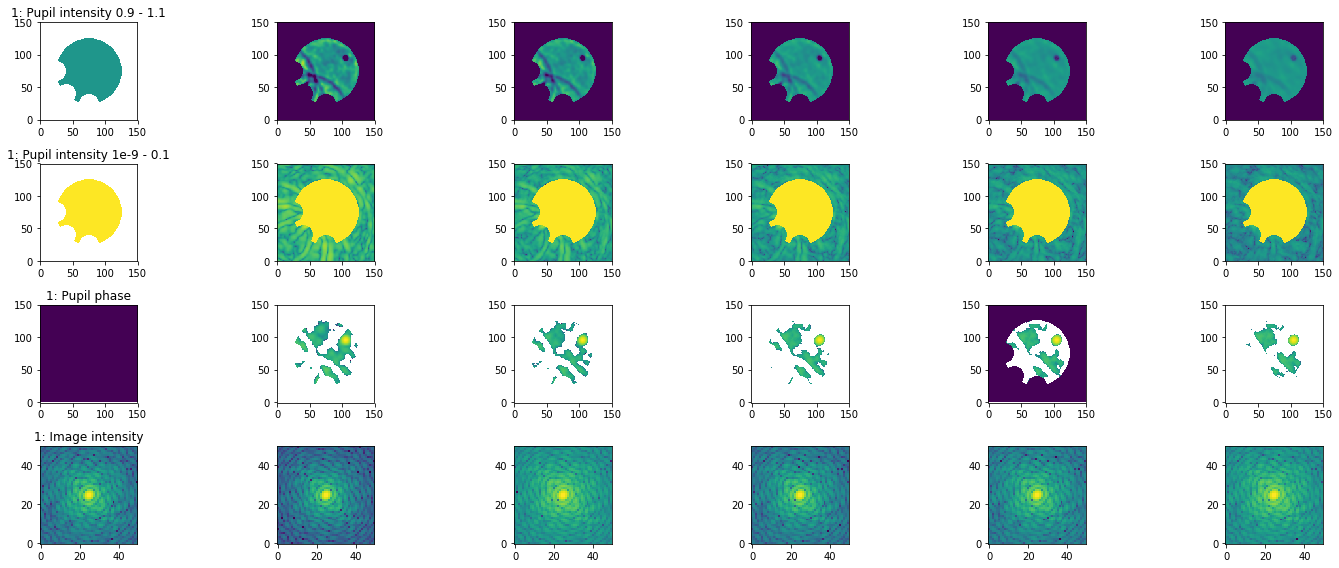

       Init Phase stats:  mean -1.0390e-18  sigma +1.0548e-01  max +1.5176e+00  min -1.4431e-02  
       Final Phase stats: mean +5.3613e-12  sigma +1.0544e-01  max +1.5173e+00  min -1.5019e-02  

Init - Final Phase stats: mean -6.8486e-21  sigma +2.4057e-04  max +5.8726e-04  min -5.8678e-04  
       Image diff stats:  mean -1.6985e-21  sigma +1.3034e-08  max +8.2151e-07  min -1.2490e-06  

All phases in radians, images total power unity


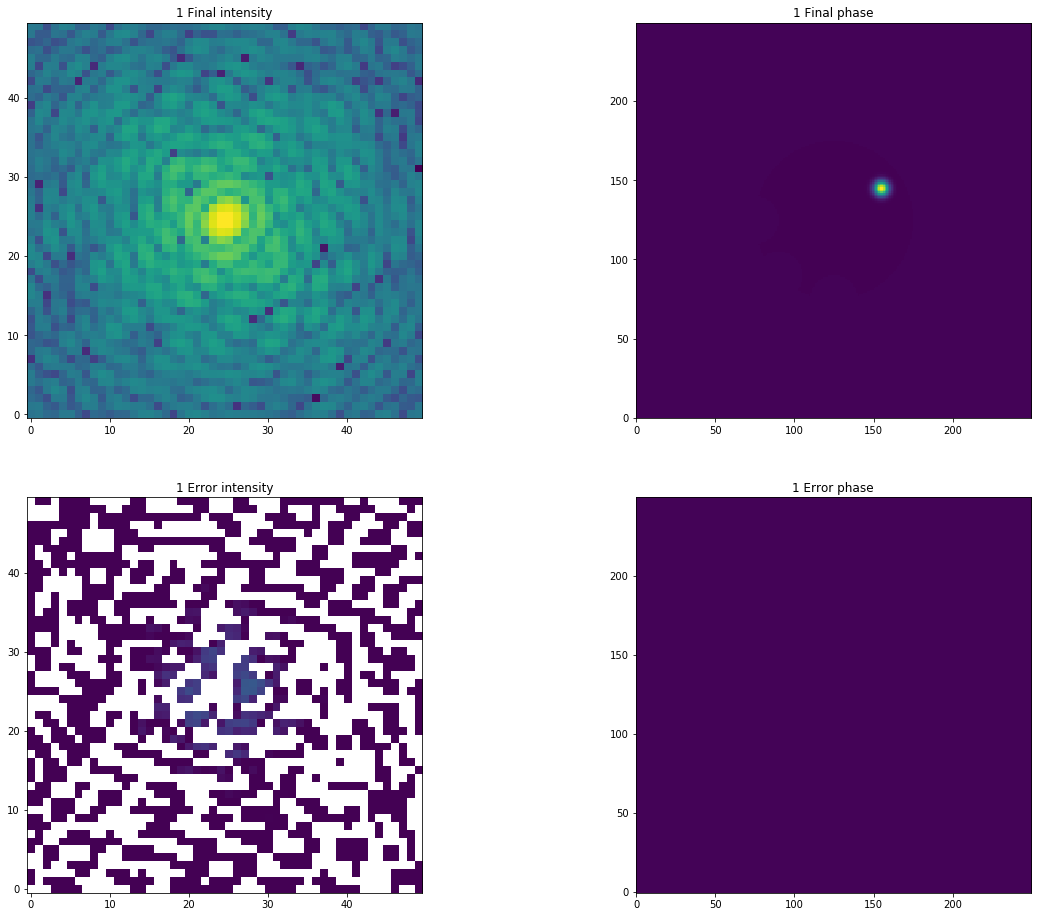

In [12]:
for pnum, (pupil, truephase, image) in enumerate(zip(pupils, phases, imgs)):
    gs = GerchbergSaxton(pupil,
                         image,
                         truephase,
                         outputtag=pnum,  # tags output files with prepended character(s)
                         initphase=None,  # initial guess, rad
                         damp=damp, # pupil phase iteration damping, dimensionless, < 1 or None (uses 1)
                         history=history, # record of which iterations you want to save for inspection later
                         threshold=threshold, # stop iterating when wavefront rms <= this, rad
                         maxiter=maxiter, # stop iterating after these number of iterations
                         verbose=False,
                         )
    gs.gsloop()
